ML For Price Prediction

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import statsmodels
import yfinance as yf

from backtesting import Strategy, Backtest 
from backtesting.lib import crossover
from backtesting.test import SMA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR


In [14]:
#get data 

aapl = yf.Ticker("AAPL") #Apple Inc. 
data = aapl.history(start="2000-01-01", end="2020-01-01")

In [27]:
#get close pr
close_prices = data['Close']

# Define the rolling window (sequence length) and prepare features
sequence_length = 10  # Use the past 10 days to predict the next day's trend
X, y = [], []

for i in range(sequence_length, len(close_prices)):
    X.append(close_prices[i-sequence_length:i].values)
    # Define target as 1 if price goes up, 0 if down
    y.append(1 if close_prices[i] > close_prices[i-1] else 0)

X, y = np.array(X), np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for better SVR performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[1])).reshape(X_test.shape)


/var/folders/bt/_3rk_crs1db0w6yym5657thc0000gn/T/ipykernel_29116/665349490.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(1 if close_prices[i] > close_prices[i-1] else 0)


In [29]:
# Initialize and train the SVR model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svr_model.fit(X_train_scaled, y_train)

# Generate predictions
predictions = svr_model.predict(X_test_scaled)

# Convert SVR outputs to binary predictions for "up" (1) or "down" (0)
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]



In [30]:
a = int(len(data))
b = int(a*0.8) #0.2 is test data 
test_data = data[b:a] #need all info not just close price in x_test 

In [31]:
from backtesting import Backtest, Strategy

class SVRStrategy(Strategy):
    def init(self):
        # Assign the predictions array to the strategy
        self.predictions = predictions_binary
        self.index = 0

    def next(self):
        if self.index < len(self.predictions):
            if self.predictions[self.index] == 1:  # Predicted "up"
                self.buy()
            else:  # Predicted "down"
                self.sell()
            self.index += 1

# Run the backtest on example data
bt = Backtest(test_data, SVRStrategy, cash=10000, commission=.002,exclusive_orders=True)
stats = bt.run()
bt.plot()


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p2658', ...)

In [33]:
stats

Start                     2015-12-31 00:00...
End                       2019-12-31 00:00...
Duration                   1461 days 00:00:00
Exposure Time [%]                    99.80139
Equity Final [$]                  1735.533075
Equity Peak [$]                  10005.610097
Return [%]                         -82.644669
Buy & Hold Return [%]              198.538386
Return (Ann.) [%]                  -35.483707
Volatility (Ann.) [%]               15.049095
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -83.911137
Avg. Drawdown [%]                  -45.385254
Max. Drawdown Duration     1432 days 00:00:00
Avg. Drawdown Duration      729 days 00:00:00
# Trades                                 1005
Win Rate [%]                        43.383085
Best Trade [%]                       6.857432
Worst Trade [%]                     -7.910494
Avg. Trade [%]                    

In [38]:
# Define the strategy with a holding period
class LSTMStrategyWithHoldingPeriod(Strategy):
    hold_period = 100  # Minimum holding period in bars (e.g., 5 days)
    
    def init(self):
        self.predictions = predictions_binary 
        self.index = 0
        self.entry_time = None  # To track when a position was opened

    def next(self):
        # Ensure we have predictions to guide actions
        if self.index < len(self.predictions):
            # If there's no position open
            if not self.position:
                # Enter a position based on prediction
                if self.predictions[self.index] == 1:
                    self.buy()  # Buy signal
                    self.entry_time = len(self.data)  # Record entry time
                else:
                    self.sell()  # Sell signal
                    self.entry_time = len(self.data)  # Record entry time
            else:
                # Check if holding period has elapsed
                if len(self.data) - self.entry_time >= self.hold_period:
                    # Close position if holding period has been met
                    self.position.close()
                    self.entry_time = None  # Reset entry time
            
            self.index += 1


bt = Backtest(test_data, LSTMStrategyWithHoldingPeriod, cash=10000, commission=.002)
stats = bt.run()
bt.plot()


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p4010', ...)

In [39]:
stats

Start                     2015-12-31 00:00...
End                       2019-12-31 00:00...
Duration                   1461 days 00:00:00
Exposure Time [%]                    99.80139
Equity Final [$]                  4341.177936
Equity Peak [$]                  12161.235228
Return [%]                         -56.588221
Buy & Hold Return [%]              198.538386
Return (Ann.) [%]                  -18.845627
Volatility (Ann.) [%]               21.280932
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -64.791681
Avg. Drawdown [%]                    -8.28278
Max. Drawdown Duration     1142 days 00:00:00
Avg. Drawdown Duration      111 days 00:00:00
# Trades                                   10
Win Rate [%]                             40.0
Best Trade [%]                      17.729455
Worst Trade [%]                    -43.214033
Avg. Trade [%]                    

LTSM with Tensorflow

In [40]:
!pip install tensorflow

     |████████████████████████████████| 239.4 MB 7.7 MB/s eta 0:00:011
     |████████████████████████████████| 5.5 MB 226 kB/s eta 0:00:01
     |████████████████████████████████| 396 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 414 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 3.1 MB/s eta 0:00:011
     |████████████████████████████████| 71 kB 603 kB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 2.9 MB/s eta 0:00:01
  Using cached h5py-3.12.1-cp39-cp39-macosx_11_0_arm64.whl (2.9 MB)
     |████████████████████████████████| 11.0 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 1.9 MB/s eta 0:00:01
  Using cached wheel-0.44.0-py3-none-any.whl (67 kB)
     |████████████████████████████████| 242 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 2.9 MB/s eta

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [57]:
# Split data into training and test sets
train_size = 0.8  # 80% training, 20% testing
train_data, test_data_bt = train_test_split(data, train_size=train_size, shuffle=False)

close_prices = train_data['Close'].values.reshape(-1, 1)

# Scale data to the range [0, 1] for LSTM model stability
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Define the sequence length (e.g., using the past 60 days to predict the next day's price)
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, sequence_length, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0264
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0016
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.1243e-04
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.9508e-04
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.6323e-04
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.9420e-04
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0010
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.8865e-04
Epoch 13/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.2898e-04
Epoch 14/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.5393e-04
Epoch 15/20
124/124 ━━━━━━

In [56]:
# Split data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size - sequence_length:]

# Prepare test sequences
X_test, y_test = [], []
for i in range(sequence_length, len(test_data)):
    X_test.append(test_data[i - sequence_length:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict and inverse scale the results
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [58]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import GOOG  # Sample data

class LSTMStrategy(Strategy):
    def init(self):
        # Predict future price movements with the LSTM model
        self.predictions = predictions  # Assumes predictions are prepared beforehand
        self.index = 0

    def next(self):
        # Sample rule: Buy if predicted price is higher than current, Sell otherwise
        if self.index < len(self.predictions) and self.predictions[self.index] > self.data.Close[-1]:
            self.buy()
        elif self.index < len(self.predictions):
            self.sell()
        
        self.index += 1

# Run the backtest on example data (e.g., GOOG for simplicity)
bt = Backtest(test_data_bt, LSTMStrategy, cash=10000, commission=.002)
stats = bt.run()
bt.plot()


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p5024', ...)

In [59]:
stats

Start                     2015-12-31 00:00...
End                       2019-12-31 00:00...
Duration                   1461 days 00:00:00
Exposure Time [%]                   49.056604
Equity Final [$]                          0.0
Equity Peak [$]                   11531.27955
Return [%]                             -100.0
Buy & Hold Return [%]              198.538386
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]             1056.548461
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -32.373545
Max. Drawdown Duration     1329 days 00:00:00
Avg. Drawdown Duration      364 days 00:00:00
# Trades                                    3
Win Rate [%]                              0.0
Best Trade [%]                     -73.628852
Worst Trade [%]                    -91.183428
Avg. Trade [%]                    

# Example from backtesting lib

In [76]:
from backtesting.test import GOOG, SMA

data = GOOG.copy()
data

,Open,High,Low,Close,Volume
2004-08-19,100.00,104.06,95.96,100.34,22351900
2004-08-20,101.01,109.08,100.50,108.31,11428600
2004-08-23,110.75,113.48,109.05,109.40,9137200
2004-08-24,111.24,111.60,103.57,104.87,7631300
2004-08-25,104.96,108.00,103.88,106.00,4598900
...,...,...,...,...,...
2013-02-25,802.30,808.41,790.49,790.77,2303900
2013-02-26,795.00,795.95,784.40,790.13,2202500
2013-02-27,794.80,804.75,791.11,799.78,2026100
2013-02-28,801.10,806.99,801.03,801.20,2265800


In [77]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

In [81]:
import numpy as np

def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values

def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y

def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.5524475524475524


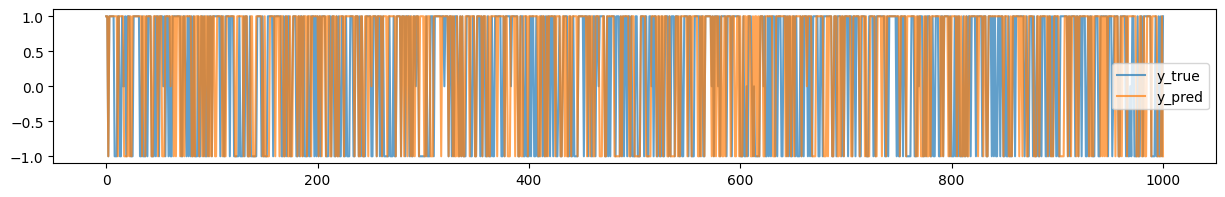

In [82]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [85]:
from backtesting import Backtest, Strategy

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

Start                     2005-01-10 00:00:00
End                       2013-03-01 00:00:00
Duration                   2972 days 00:00:00
Exposure Time [%]                   22.889214
Equity Final [$]                    64.767236
Equity Peak [$]                       10000.0
Return [%]                         -99.352328
Buy & Hold Return [%]              313.303599
Return (Ann.) [%]                  -46.194639
Volatility (Ann.) [%]                8.352978
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.352328
Avg. Drawdown [%]                  -99.352328
Max. Drawdown Duration     2395 days 00:00:00
Avg. Drawdown Duration     2395 days 00:00:00
# Trades                                  467
Win Rate [%]                        10.920771
Best Trade [%]                       0.761212
Worst Trade [%]                     -3.334242
Avg. Trade [%]                    

In [86]:
bt.plot()

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p6320', ...)

In [87]:
stats = bt.optimize(price_delta=list(np.array(range(1, 10, 1))*0.001), maximize='Equity Final [$]')
stats

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


Start                     2005-01-10 00:00:00
End                       2013-03-01 00:00:00
Duration                   2972 days 00:00:00
Exposure Time [%]                   23.670083
Equity Final [$]                    66.876012
Equity Peak [$]                       10000.0
Return [%]                          -99.33124
Buy & Hold Return [%]              313.303599
Return (Ann.) [%]                  -45.982198
Volatility (Ann.) [%]                7.552992
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -99.33124
Avg. Drawdown [%]                   -99.33124
Max. Drawdown Duration     2395 days 00:00:00
Avg. Drawdown Duration     2395 days 00:00:00
# Trades                                  484
Win Rate [%]                         6.818182
Best Trade [%]                       0.329125
Worst Trade [%]                     -3.237188
Avg. Trade [%]                    

In [88]:
stats._strategy

<Strategy MLTrainOnceStrategy(price_delta=0.003)>